<a href="https://colab.research.google.com/github/JeromeUwU/Computer-Vision/blob/main/Diffusion_Transformer_(DiT)_for_Chest_X_ray_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffusion Transformer (DiT) for Chest X-ray Generation

This notebook implements a **Diffusion Transformer (DiT)** for **conditional generation of chest X-rays**.  
The goal is to **synthesize realistic medical images** (NIH CXR14 dataset) conditioned on pathology labels  
(e.g. *Effusion, Cardiomegaly, Pneumothorax*). Such models can help with **data augmentation** in medical AI,  
where annotated data is scarce.

---

## Overview of the Approach

- **Autoencoder (VAE):** Encodes chest X-rays from image space (256×256) into a compressed latent space (32×32).
- **Diffusion Process:** Noise is gradually added to latent variables and the model learns to predict and remove it.
- **Diffusion Transformer (DiT):** A Vision Transformer backbone predicts noise given the noised latent, timestep, and pathology condition.
- **Classifier-Free Guidance (CFG):** Allows balancing unconditional and conditional generations during sampling.
- **DDIM Sampling:** Deterministic sampling method used to generate high-quality images from the trained model.

---

## Mathematical Formulation

The forward diffusion process corrupts a clean latent $z_0$ into a noisy latent $z_t$:

$$
q(z_t \mid z_0) = \sqrt{\alpha_t}\, z_0 + \sqrt{1 - \alpha_t}\, \epsilon,
\quad \epsilon \sim {N}(0, I)
$$

The model learns to predict the noise $\epsilon$ with a Transformer parameterized by $\theta$:

$$
L(\theta) =
\mathbb{E}_{z_0, \epsilon, t, y}\left[
  \| \epsilon - \epsilon_\theta(z_t, t, y) \|^2
\right]
$$

During inference, the model starts from pure Gaussian noise $z_T$ and progressively denoises it using DDIM steps:

$$
z_{t-1} = \sqrt{\alpha_{t-1} }, \hat{z}_0 + \sqrt{1 - \alpha_{t-1} }, \epsilon_\theta(z_t, t, y)
$$


---

## Training Setup
- Dataset: **NIH ChestX-ray14**
- Image size: **256 × 256** (grayscale, repeated to 3 channels for the VAE)
- Latent size: **32 × 32 × 4**
- Transformer backbone: **DiT with 16 layers, 12 heads**
- Training objective: **Noise prediction MSE**

---

Note : Most of the training was done with collab A100 GPU which is faster than Kaggle's P100

# Dataloader and process

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
nih_chest_xrays_data_path = kagglehub.dataset_download('nih-chest-xrays/data')

print('Data source import complete.')


100%|██████████| 42.0G/42.0G [18:24<00:00, 40.8MB/s]

Extracting files...


Data source import complete.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

dataset_path = '/root/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3'

for item in os.listdir(dataset_path):
  print(item)


Data_Entry_2017.csv
test_list.txt
images_005
images_003
images_010
LOG_CHESTXRAY.pdf
images_011
images_001
images_004
images_002
images_006
images_012
ARXIV_V5_CHESTXRAY.pdf
train_val_list.txt
README_CHESTXRAY.pdf
FAQ_CHESTXRAY.pdf
images_008
images_009
BBox_List_2017.csv
images_007


In [ ]:
print(nih_chest_xrays_data_path)

/root/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3


In [ ]:
import os
from glob import glob


import numpy as np
import pandas as pd
import math


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.model_selection import GroupShuffleSplit
from diffusers import AutoencoderKL

import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler

In [ ]:
all_xray_df = pd.read_csv('/root/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3/Data_Entry_2017.csv')
my_glob = glob('/root/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3/images*/images/*.png')
print('Number of observations:',len(all_xray_df))
print('Number of Observations: ', len(my_glob))

Number of observations: 112120
Number of Observations:  112120


In [ ]:
full_img_paths = {os.path.basename(x): x for x in my_glob}
all_xray_df['full_path'] = all_xray_df['Image Index'].map(full_img_paths.get)

In [ ]:
FINDINGS = [
    'Atelectasis','Consolidation','Infiltration','Pneumothorax','Edema',
    'Emphysema','Fibrosis','Effusion','Pneumonia','Pleural_Thickening',
    'Cardiomegaly','Nodule','Mass','Hernia'
]


def to_multihot(s: str):
    if s == 'No Finding':
        return {k: 0.0 for k in FINDINGS}
    items = [x.strip() for x in s.split('|')]
    return {k: float(k in items) for k in FINDINGS}

multi_cols = all_xray_df['Finding Labels'].apply(to_multihot).apply(pd.Series)
all_xray_df = pd.concat([all_xray_df, multi_cols], axis=1).reset_index(drop=True)


In [ ]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
train_idx, val_idx = next(gss.split(all_xray_df, groups=all_xray_df['Patient ID']))

train_df = all_xray_df.iloc[train_idx].reset_index(drop=True)
val_df   = all_xray_df.iloc[val_idx].reset_index(drop=True)

print(len(train_df))
print(len(val_df))

89826
22294


In [ ]:
class NIHMultiLabelDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
        self.tx = T.Compose([
            T.Grayscale(num_output_channels=1),
            T.Resize(256), T.CenterCrop(256),
            T.ToTensor(),                      # [0,1]
            T.Normalize(mean=[0.5], std=[0.5]) # -> [-1,1]
        ])
        self.findings = FINDINGS

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]

        img = Image.open(f"{row['full_path']}").convert("L")

        x = self.tx(img) # (1,256,256)

        y = torch.tensor(np.array(row[self.findings].values,dtype = float), dtype=torch.float32)  # (K,)
        return x, y

In [ ]:
generator = torch.Generator()
generator.manual_seed(42)

train_dataset = NIHMultiLabelDataset(train_df)
test_dataset = NIHMultiLabelDataset(val_df)


train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True,
    persistent_workers=True,
    prefetch_factor=2,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    drop_last=False,
    persistent_workers=True,
    prefetch_factor=2,
)


#for batch in train_loader:
#    img, label = batch
#    break
#print(img.shape)
#print(label.shape)

#  Latent Space via a Pretrained VAE



We work in **latent space** instead of pixel space for efficiency and stability.  
A pretrained **AutoencoderKL** (the Stable Diffusion VAE) maps images $$(x\in[-1,1]^{H\times W\times 3})$$ to latents
$$(z\in\mathbb{R}^{h\times w\times c_z})$$ with $$(h=W/8,\; w=H/8,\; c_z=4).$$

## Setup
- `IMG_SIZE = 256` → latent size `LATENT_SIZE = 32`
- `CZ = 4` latent channels (standard SD VAE)
- We **freeze** the VAE weights (no training) and only use it as a codec.

## Encoder / Decoder
The VAE defines a Gaussian posterior:

$$
q_\phi(z\,|\,x)=N\big(\mu_\phi(x),\,\sigma_\phi^2(x)\,I\big)
$$

During training of our diffusion model we use the **deterministic mean** (less stochasticity):

$$
z \;=\; s \cdot \mu_\phi(x), \qquad s=\texttt{scaling_factor}=0.18215,
$$

where $s$ matches the scale used in Stable Diffusion so that latent magnitudes align.

The decoder approximates the inverse mapping:

$$
\hat{x} \;=\; \text{Dec}_\phi\!\left(\frac{z}{s}\right),\qquad \hat{x}\in[-1,1]^{H\times W\times 3}.
$$

Because NIH CXR images are grayscale, we:

1) repeat the single channel to **3 channels** before encoding,  

2) keep only the **first channel** after decoding:

$$
x^{(3)} = \text{repeat}(x,3),\quad
\hat{x}^{(1)} = \hat{x}_{[:,:,\;0]}.
$$

## Why latent space?
- $(32\times 32\times 4)$ latents are **64× smaller** than $(256\times 256\times 1)$ pixels → faster training and larger context for the Transformer.
- The VAE concentrates semantics (lungs, edges, textures) into \(z\), making the diffusion task easier.

**Functions used here**
- `encode_to_latents(x)` returns $(z = s\cdot \mu_\phi(x)\in\mathbb{R}^{B\times 4\times 32\times 32})$.
- `decode_from_latents(z)` returns a clamped grayscale reconstruction $(\hat{x}\in[-1,1]^{B\times 1\times 256\times 256})$.

> Note: using the posterior **mean** (instead of sampling) reduces gradient noise and improves stability of the DiT training.



In [ ]:
torch.backends.cudnn.benchmark = True
device = "cuda" if torch.cuda.is_available() else "cpu"
K = 14
IMG_SIZE = 256
LATENT_SIZE = IMG_SIZE // 8   # 32
CZ = 4                         # VAE latent channels
PATCH = 2                      # 2x2 latent patches → 16x16 = 256 tokens


In [ ]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").to(device).eval()
for p in vae.parameters(): p.requires_grad = False
scaling = getattr(vae.config, "scaling_factor", 0.18215)

In [ ]:
@torch.no_grad()
def encode_to_latents(x1):  # x1 : (B, 1, 256, 256) -> [-1, 1]
    assert x1.ndim == 4, f"Expected 4D tensor, got {x1.shape}"
    B, C, H, W = x1.shape
    assert C in (1, 3), f"Expected channels=1 or 3, got {C} with shape {x1.shape}"
    assert H == 256 and W == 256, f"Expected 256x256, got {H}x{W}"

    # (B,3,H,W)
    if C == 1:
        x3 = x1.repeat(1, 3, 1, 1)
    else:
        x3 = x1

    # optional
    x3 = x3.contiguous()

    dist = vae.encode(x3).latent_dist
    z = dist.mean  * scaling  # (B, 4, 32, 32)
    return z

@torch.no_grad()
def decode_from_latents(z):                   # (B,4,32,32)
    x3 = vae.decode(z / scaling).sample       # (B,3,256,256)
    x1 = x3[:, :1]
    return x1.clamp(-1, 1)


In [ ]:
#z = encode_to_latents(img.to(device))
#print(z.shape)
#reco_im = decode_from_latents(z)
#print(reco_im.shape)

In [ ]:
def display_img(img):
    if img.device.type == 'cuda':
        image_np = img.cpu().permute(1, 2, 0).numpy()
    else:
        image_np = img.permute(1, 2, 0).numpy()

    plt.imshow(image_np)
    plt.axis('off')
    plt.show()

#print("Reconstruction: \n")
#display_img(reco_im[0])
#print("\n Original: \n")
#display_img(img[0])

# Condition Embedding Network (CondMLP)



Our diffusion model must be **conditioned** on medical findings (labels) from the NIH ChestX-ray dataset.  
We represent each label vector $y \in \{0,1\}^K$ (multi-hot over \(K=14\) possible findings) as a dense embedding that the Transformer can use.

## CondMLP architecture
The conditioning network is a simple **multi-layer perceptron**:

$$
f_\theta: \mathbb{R}^K \;\to\; \mathbb{R}^{d_\text{model}},
$$

where $d_\text{model}=768$ is the hidden dimension of the DiT Transformer.

Steps:

1. **Input**: $y \in \{0,1\}^K$ (multi-hot label for each finding).

2. **Projection**: Linear layer maps $(K \to 512)$.

3. **Activation**: GELU non-linearity adds smooth curvature.

4. **Normalization**: LayerNorm stabilizes the embedding.

5. **Final projection**: Linear layer maps $(512 \to d_\text{model})$.


Formally:
$$
e_y \;=\; W_2\,\text{LN}(\,\text{GELU}(W_1 y + b_1)\,) + b_2, \qquad e_y \in \mathbb{R}^{d_\text{model}}.
$$

## Why do this?

- The raw label vector $y$ is very **sparse** and discrete.  

- The Transformer requires a **continuous embedding** of the same dimension as its token embeddings $(d_\text{model})$.  

- This embedding $e_y$ is treated like a **special token** inside DiT, allowing the model to generate images conditioned on medical findings.


**Function**
- `CondMLP(y)` outputs $(e_y \in \mathbb{R}^{B \times d_\text{model}})$.  

- Used during training and inference for **classifier-free guidance** (sometimes replaced by the zero-vector to simulate unconditional generation).


## Classifier-Free Guidance (CFG)

In conditional diffusion models, we want to generate images that match a condition (here: medical findings),  
but we also want flexibility to balance **fidelity** (realism) vs **alignment** (matching the condition).

### Idea
- During training, we **randomly drop the condition** with probability $(p)$ set $y=0$.  

- This way, the model learns **both**:
  1. An **unconditional score estimator** $( \hat\epsilon_\text{uncond}(z_t, t))$,

  2. A **conditional score estimator** $( \hat\epsilon_\text{cond}(z_t, t, y))$.

At inference, we combine both with a guidance scale $\gamma$:

$$
\hat\epsilon(z_t, t, y) \;=\; \hat\epsilon_\text{uncond}(z_t, t)
+ \gamma \,\big( \hat\epsilon_\text{cond}(z_t, t, y) - \hat\epsilon_\text{uncond}(z_t, t)\big).
$$

- If $(\gamma=1)$: normal conditional generation.  

- If $(\gamma>1)$: stronger conditioning (images adhere more strictly to labels, but risk artifacts).  

- If $(\gamma=0)$: unconditional generation (ignore labels).  

### Why it matters

- Avoids the need for an **external classifier** to guide the generation.  

- Very important in **medical imaging**: it allows us to control the strength of conditioning on diseases while keeping image quality.

### In our code

- `CondMLP(y)` → produces conditional embedding $(e_y)$.

- With prob $(p=0.2)$, we replace $(y)$ by a zero-vector (unconditional).  

- At inference, we explicitly compute both unconditional and conditional predictions and interpolate using CFG scale.



In [ ]:
class CondMLP(nn.Module):
    def __init__(self, K, d_model=768):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(K, 512),
            nn.GELU(),
            nn.LayerNorm(512),
            nn.Linear(512, d_model)
        )
    def forward(self, y):
        return self.net(y)


In [ ]:
#mlp = CondMLP(K=K).to(device)
#txt_emb = mlp(label.to(device))
#print(txt_emb.shape)

# Timestep Embeddings and Noise Schedule

In diffusion models, every training example is associated with a **diffusion step** $(t \in \{1, \dots, T\})$.  

At each step, noise is gradually added, and the model must learn to **predict and remove that noise**.

---

## Sinusoidal Timestep Embedding
The function `sin_timestep_embed(t, dim)` encodes the timestep $(t)$ into a **vector representation**:

$$
\text{PE}(t, 2i)   = \sin\!\Big(t \cdot \omega_i\Big),
\quad
\text{PE}(t, 2i+1) = \cos\!\Big(t \cdot \omega_i\Big)
$$

where frequencies are exponentially spaced:
$$
\omega_i = \exp\!\Big(- \tfrac{\log(10000)}{d/2 - 1} \cdot i \Big).
$$

- This is similar to **positional embeddings** in Transformers.  
- It allows the model to "know" *how much noise has been added*, in a continuous way.  
- Produces a vector of size `dim`, later projected by `TimeMLP`.

---

## TimeMLP
The class `TimeMLP` takes the sinusoidal embedding and passes it through a small MLP:

$$
e_t = \text{MLP}(\text{PE}(t)) \quad \in \mathbb{R}^{d_\text{model}}.
$$

This learns a **richer, non-linear representation of time**, better adapted to the model’s hidden dimension ($d_\text{model}=768$).

---

## Cosine Noise Schedule
The class `CosNoiseSchedule` defines how noise is added across timesteps.  
Instead of a linear schedule, we use a **cosine schedule** ([Nichol & Dhariwal, 2021](https://arxiv.org/abs/2102.09672)):

$$
\bar\alpha_t = \frac{\cos^2\!\Big( \tfrac{t/T + s}{1+s}\cdot \tfrac{\pi}{2} \Big)}{\cos^2\!\Big( \tfrac{s}{1+s}\cdot \tfrac{\pi}{2} \Big)}
$$

- $(\bar\alpha_t)$ = cumulative product of noise retention up to step $(t)$.  
- Controls how much signal vs noise remains in the latent at time $(t)$.  
- Provides a **smoother decay** than linear schedules, empirically leading to better sample quality.

The method `sample_timesteps(B, device)` randomly selects timesteps for a batch during training,  
so the model sees examples from *all noise levels*.

---

## Intuition
- **Time embedding** tells the model *“how corrupted this image is.”*  
- **Noise schedule** decides *“how fast the corruption happens.”*  
Together, they let the model learn a consistent denoising process.


In [ ]:
def sin_timestep_embed(t, dim):
    # t: (B,) int ou float timesteps
    half = dim // 2
    freqs = torch.exp(torch.arange(half, device=t.device) * (-torch.log(torch.tensor(10000.0)) / (half-1)))
    args = t.float().unsqueeze(1) * freqs.unsqueeze(0)
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
    if dim % 2 == 1: emb = F.pad(emb, (0,1))
    return emb  # (B, dim)

class TimeMLP(nn.Module):
    def __init__(self, d_model=768):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Linear(d_model, d_model)
        )
    def forward(self, t):
        t_emb = sin_timestep_embed(t, self.mlp[0].in_features)
        return self.mlp(t_emb)


class CosNoiseSchedule:
    def __init__(self, T=1000, s=0.008):
        self.T = T
        t = torch.arange(T+1, dtype=torch.float32)
        f = torch.cos(((t/T + s) / (1+s)) * math.pi * 0.5) ** 2
        self.alpha_bar = (f / f[0]).clamp(min=1e-8)  # (T+1,)

    def sample_timesteps(self, B, device):
        return torch.randint(1, self.T, (B,), device=device, dtype=torch.long)



In [ ]:
#sched = CosNoiseSchedule(T=1000)
#time_mlp = TimeMLP().to(device)
#B = img.size(0)
#t = sched.sample_timesteps(B, device)
#t_emb = time_mlp(t)
#print(B)
#print(t.shape)
#print(t_emb.shape)

# From Latents to Tokens + Forward Diffusion

## LatentTokenizer — patchify the latent and make Transformer tokens

Our VAE latent $(z \in \mathbb{R}^{B \times C_z \times 32 \times 32})$ is **patchified** into non-overlapping $(p \times p)$ tiles, then each tile is projected to the Transformer width $d_\text{model}$.

- With `PATCH = p = 2`, the $32\times 32$ latent becomes a $16\times 16$ grid → **256 tokens**.

- Each token corresponds to one $(C_z \cdot p \cdot p)$-dimensional vector, linearly **projected** to $\mathbb{R}^{d_\text{model} }$.

- We add a learnable **positional embedding** so the Transformer knows each token’s spatial location.

Formally, let $z$ be unfolded into patches $\{\pi_{i}\}_{i=1}^{N}$ with
$$
N = \Big(\tfrac{32}{p}\Big)^2,\qquad \pi_i \in \mathbb{R}^{C_z \cdot p \cdot p}.
$$
Then
$$
\text{token}_i \;=\; W\,\pi_i + b \;+\; \text{pos}_i \;\in\; \mathbb{R}^{d_\text{model}},
$$
and the tokenizer outputs a sequence $\in \mathbb{R}^{B \times N \times d_\text{model}}$.

**Why patchify?**  

Transformers operate on sequences. Patching:

- preserves **locality** (each token = local latent patch),

- reduces sequence length vs pixels (256 tokens ≪ 65,536 pixels),

- keeps enough spatial resolution for global attention to be effective.

---

## Forward noising: `q_sample`

During training, we corrupt the **clean latent** $z_0$ into a noisy latent $z_t$ using the schedule $\bar\alpha_t$:
$$
z_t \;=\; \sqrt{\bar\alpha_t}\, z_0 \;+\; \sqrt{1-\bar\alpha_t}\, \epsilon,\qquad
\epsilon \sim N(0, I).
$$
In code:

```python
a_bar = sched.alpha_bar.to(z0.device)[t].view(-1,1,1,1)
z_t = a_bar.sqrt() * z0 + (1.0 - a_bar).sqrt() * eps




$\bar\alpha_t$ is the cumulative signal-to-noise at step $t$ (from the cosine schedule).

Sampling random $t$ exposes the model to all noise levels.

The DiT then learns to predict $\epsilon$ from the tokenized $z_t$ , given the time and condition embeddings.

**Intuition**:

**LatentTokenizer** prepares the input sequence for the Transformer.

**q_sample** applies the mathematically defined forward diffusion so the model can learn to invert it (denoise) during training.

In [ ]:
class LatentTokenizer(nn.Module):
    def __init__(self, cz=CZ, patch=PATCH, d_model=768):
        super().__init__()
        self.cz = cz; self.p = patch
        self.proj = nn.Linear(cz*patch*patch, d_model)
        self.pos = nn.Parameter(torch.zeros(1, (LATENT_SIZE//patch)**2, d_model))
        nn.init.normal_(self.pos, std=0.02)

    def forward(self, z):  # z: (B,CZ,32,32)
        B, C, H, W = z.shape
        assert C == self.cz and H % self.p == 0 and W % self.p == 0
        z = z.unfold(2, self.p, self.p).unfold(3, self.p, self.p)  # (B,C,H/p,W/p,p,p)
        z = z.permute(0,2,3,1,4,5).contiguous().view(B, -1, C*self.p*self.p)  # (B,256,C*p*p)
        tokens = self.proj(z) + self.pos  # (B,256,d_model)
        return tokens

def q_sample(z0, t, eps):
    a_bar = sched.alpha_bar.to(z0.device)[t].view(-1,1,1,1)
    return (a_bar.sqrt() * z0) + ((1.0 - a_bar).sqrt() * eps)

In [ ]:
#eps = torch.randn_like(z)
#zt = q_sample(z, t, eps)
#tok = LatentTokenizer().to(device)
#patch_tokens = tok(zt)
#print(patch_tokens.shape)

# Diffusion Transformer (DiT): Blocks, Conditioning Tokens & EMA

This section defines the **Transformer backbone** that predicts the noise $\epsilon$ on latent patches, plus an **EMA** wrapper for stable evaluation.

---

## TransformerBlock — pre-norm self-attention + MLP

Each block is a standard **pre-norm** Transformer layer with residuals:

1. **LayerNorm → Multi-Head Self-Attention → Residual**

2. **LayerNorm → MLP (GELU, width = $4\times d$) → Residual**

3. Optional **stochastic depth** via `drop_path` (DropPath-style residual dropout).

Self-attention over the token sequence $X \in \mathbb{R}^{B\times N\times d}$:

$$
\mathrm{Attn}(X) = \mathrm{softmax}\!\left(\frac{QK^\top}{\sqrt{d_k}}\right)V,
\quad
Q = XW_Q,\; K=XW_K,\; V=XW_V.
$$

Residual pre-norm updates:

$$
X \leftarrow X + \mathrm{DropPath}\big(\mathrm{Attn}(\mathrm{LN}(X))\big),\quad
X \leftarrow X + \mathrm{DropPath}\big(\mathrm{MLP}(\mathrm{LN}(X))\big).
$$

**Why this design?**

- **Pre-norm** improves gradient flow in deep Transformers.

- **DropPath** regularizes depth-wise and helps prevent overfitting/instability.

- **MLP ratio 4.0** (hidden = $4d$) is a strong default for ViT/DiT.

---

## DiT — tokens = [time | cond | 256 patch tokens]

We convert the latent $z_t \in \mathbb{R}^{B\times C_z \times 32 \times 32}$ into a sequence of **256 patch tokens** (see `LatentTokenizer`), and **prepend two special tokens**:

- **`time_tok`**: projection of the **timestep embedding** $e_t \in \mathbb{R}^{d}$.

- **`cond_tok`**: projection of the **condition embedding** $e_y \in \mathbb{R}^{d}$ (from `CondMLP`).

The input to the stack is:

$$
X_0 = \big[\, e_t \;\|\; e_y \;\|\; \text{patch_tokens}\,\big] \in \mathbb{R}^{B\times (2+256)\times d}.
$$

After `depth` Transformer blocks + final LayerNorm, we **discard the first two tokens** (time/cond) and map the 256 patch outputs back to per-patch noise via a linear **head**:

$$
\hat\epsilon_{\text{tokens}} \in \mathbb{R}^{B\times 256 \times (C_z p^2)} \;\xrightarrow{\text{reshape}}\;
\hat\epsilon \in \mathbb{R}^{B\times C_z \times 32 \times 32}.
$$

**Why prepend time/cond tokens?**

- They act as **global context** that every patch can attend to, letting the model inject **timestep** and **label** information into all spatial locations.

- Simpler than cross-attention, yet effective for DiT.

**Why global attention over all patches?**

- Captures **long-range structure** (lungs, heart silhouette) while keeping locality via patching.

---

## EMA — Exponential Moving Average of weights

We maintain a **shadow copy** $\theta_{\text{EMA}}$ of model parameters for more stable sampling/evaluation:

$$
\theta_{\text{EMA}} \leftarrow \beta\,\theta_{\text{EMA}} + (1-\beta)\,\theta,
\quad \beta \approx 0.9999 \text{–} 0.99995.
$$

- Apply **`ema.update()`** after each optimizer step.

- For previews/exports, **copy EMA weights** into the live model (`ema.copy_to()`), generate, then restore.

- EMA reduces prediction noise and typically **improves sample quality** without changing training dynamics.

---

### 🔚 Summary

- **TransformerBlock**: pre-norm SA + MLP with residuals & DropPath → stable deep sequence modeling.

- **DiT**: sequence = `[time | cond | 256 patches]` → global attention propagates conditioning to all patches; head predicts $\hat\epsilon$ per patch.

- **EMA**: a low-pass filter on parameters → smoother, higher-quality generations at test time.


In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model=768, nhead=12, mlp_ratio=4.0, drop=0.0, drop_path=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.attn  = nn.MultiheadAttention(d_model, nhead, dropout=drop, batch_first=True)
        self.norm2 = nn.LayerNorm(d_model)
        self.mlp   = nn.Sequential(
            nn.Linear(d_model, int(d_model*mlp_ratio)),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(int(d_model*mlp_ratio), d_model),
            nn.Dropout(drop)
        )
        self.drop_path = drop_path
    def forward(self, x):
        # x: (B, 258, d_model) → time/cond + 256 patch tokens
        h = x
        x = self.norm1(x)
        x,_ = self.attn(x, x, x, need_weights=False)
        x = h + F.dropout(x, p=self.drop_path, training=self.training)
        h = x
        x = self.norm2(x)
        x = h + F.dropout(self.mlp(x), p=self.drop_path, training=self.training)
        return x

class DiT(nn.Module):
    def __init__(self, d_model=768, depth=16, nhead=12, cz=CZ, patch=PATCH):
        super().__init__()
        self.tokenizer = LatentTokenizer(cz, patch, d_model)
        self.time_proj = nn.Linear(d_model, d_model)  # optional
        self.cond_proj = nn.Linear(d_model, d_model)
        self.blocks = nn.ModuleList([TransformerBlock(d_model, nhead) for _ in range(depth)])
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, cz*patch*patch)  # predict  ε
        self.d_model = d_model
        self.patch = patch
        self.cz = cz

    def forward(self, z_t, t_emb, cond_emb):
        # tokens
        patch_tokens = self.tokenizer(z_t)  # (B,256,d)
        time_tok = self.time_proj(t_emb).unsqueeze(1)   # (B,1,d)
        cond_tok = self.cond_proj(cond_emb).unsqueeze(1)# (B,1,d)
        x = torch.cat([time_tok, cond_tok, patch_tokens], dim=1)  # (B,258,d)

        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        # moins 2 tokens; decode les patch tokens
        patch_out = x[:, 2:, :]                           # (B,256,d)
        eps_tokens = self.head(patch_out)                 # (B,256,cz*p*p)

        # reshape latent (B,cz,32,32)
        B = z_t.size(0)
        h = w = LATENT_SIZE // self.patch                 # 16
        eps = eps_tokens.view(B, h, w, self.cz, self.patch, self.patch)
        eps = eps.permute(0,3,1,4,2,5).contiguous().view(B, self.cz, LATENT_SIZE, LATENT_SIZE)
        return eps

class EMA:
    def __init__(self, model, decay=0.9999):
        self.m = model
        self.shadow = {k:v.detach().clone() for k,v in model.state_dict().items()}
        self.decay = decay
    @torch.no_grad()
    def update(self):
        for k,v in self.m.state_dict().items():
            self.shadow[k].mul_(self.decay).add_(v.detach(), alpha=1-self.decay)
    @torch.no_grad()
    def copy_to(self):
        self.m.load_state_dict(self.shadow, strict=False)



## Training functions

**Goal:** teach the DiT to predict the injected noise in VAE latent space, conditioned on pathology labels.

### Pipeline per batch
1) **Inputs**  
   - Images $x \in [-1,1]^{B\times1\times256\times256}$

   - Multi-hot labels $y \in \{0,1\}^{B\times K}$

2) **Encode to latent space (frozen VAE)**  
   - Repeat grayscale → 3 channels, encode with VAE, take posterior mean:

     $
     z_0 = s \cdot \mu_\phi(x), \quad z_0 \in \mathbb{R}^{B\times C_z\times 32\times 32}
     $

   - $s$ = scaling_factor (0.18215)

3) **Sample diffusion step & add noise (forward process)**  

   - Sample $t \sim U\{1,\dots,T\}$, $\epsilon \sim N(0,I)$

   - Cosine schedule \(\bar\alpha_t\) →  
     $
     z_t = \sqrt{\bar\alpha_t}\, z_0 + \sqrt{1-\bar\alpha_t}\,\epsilon
     $

4) **Build conditioning**  

   - **Classifier-Free Guidance (CFG) drop:** with prob $p$, replace $y$ by 0 (uncond) → $y_{\text{drop}}$

   - **Embeddings:**  
     $$
     e_y = \mathrm{CondMLP}(y_{\text{drop}}), \quad e_t = \mathrm{TimeMLP}(\mathrm{PE}(t))
     $$

5) **Predict noise with DiT**  

   - Patchify \(z_t\) → 256 tokens; prepend $[e_t \mid e_y]$

   - Transformer predicts per-patch noise $\hat\epsilon = \epsilon_\theta(z_t, t, y)$

6) **Loss & optimization**  

   - Noise prediction MSE:  
     $$
     Loss = \| \hat\epsilon - \epsilon \|_2^2
     $$

   - AMP mixed precision, gradient clip, AdamW step  

   - **EMA update** of model weights for stable sampling

   - **LR schedule:** warmup → cosine decay

### Validation flow (differences)

- No CFG drop (use true y)  
- No optimizer/EMA updates; just compute MSE

**Summary**  
VAE encodes images → add scheduled noise → DiT sees $(z_t, t, y)$ and learns to predict the exact noise we added. Lower MSE ⇒ better denoiser ⇒ higher-quality conditional generations at inference.


In [ ]:
from torch.amp import autocast, GradScaler


best_val = float('inf')
global_step = 0
epoch = 0
log_every = 500

sched = CosNoiseSchedule(T=1000)
d_model = 768
cond_mlp = CondMLP(K, d_model).to(device)
time_mlp = TimeMLP(d_model).to(device)
dit = DiT(d_model=d_model, depth=16, nhead=12, cz=CZ, patch=PATCH).to(device)
ema = EMA(dit, 0.9999)


base_lr = 1e-4
warmup_steps = 2000
total_steps  = 200_000


opt = torch.optim.AdamW(
    list(dit.parameters()) + list(cond_mlp.parameters()) + list(time_mlp.parameters()),
    lr=base_lr, betas=(0.9,0.999), weight_decay=1e-2
)
def lr_lambda(step):
    if step < warmup_steps: return (step+1)/warmup_steps
    prog = (step - warmup_steps)/max(1, total_steps - warmup_steps)
    return 0.5*(1+math.cos(math.pi*prog))

sched_lr = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)

cfg_drop_p = 0.2


scaler = GradScaler("cuda")

if os.path.exists("/content/drive/MyDrive/Colab Notebooks/DiT/best_dit_ckpt.pt"):
    ckpt = "/content/drive/MyDrive/Colab Notebooks/DiT/best_dit_ckpt.pt"

    state = torch.load(ckpt, map_location=device)
    dit.load_state_dict(state["dit"])
    cond_mlp.load_state_dict(state["cond_mlp"])
    time_mlp.load_state_dict(state["time_mlp"])
    opt.load_state_dict(state["opt"])
    sched_lr.load_state_dict(state["lr_sched"])
    ema.shadow = state["ema"]; ema.copy_to()
    global_step = state["global_step"]
    best_val = state["best_val"]
    epoch = state["epoch"]


def train_step(batch):

    dit.train()
    cond_mlp.train()
    time_mlp.train()

    x,y = (b.to(device, non_blocking=True) for b in batch)
    with torch.no_grad():
        z0 = encode_to_latents(x)
    B = x.size(0)
    t = sched.sample_timesteps(B, device)
    eps = torch.randn_like(z0)
    zt = q_sample(z0, t, eps)

    use_cond = (torch.rand(B, device=device) > cfg_drop_p).float().unsqueeze(1)
    y_drop = y * use_cond

    opt.zero_grad(set_to_none=True)
    with autocast("cuda", enabled=True):
        cond_emb = cond_mlp(y_drop)
        t_emb    = time_mlp(t)
        eps_hat  = dit(zt, t_emb, cond_emb)
        loss     = F.mse_loss(eps_hat, eps)

    scaler.scale(loss).backward()
    scaler.unscale_(opt)
    nn.utils.clip_grad_norm_(dit.parameters(), 0.5)
    scaler.step(opt)
    ema.update()
    scaler.update()
    sched_lr.step()
    return float(loss.detach())

def val_step(batch):

    dit.eval()
    cond_mlp.eval()
    time_mlp.eval()

    x,y = (b.to(device, non_blocking=True) for b in batch)
    with torch.no_grad():
        z0 = encode_to_latents(x)
        B = x.size(0)
        t = sched.sample_timesteps(B, device)
        eps = torch.randn_like(z0)
        zt = q_sample(z0, t, eps)
        cond_emb = cond_mlp(y)
        t_emb    = time_mlp(t)
        eps_hat  = dit(zt, t_emb, cond_emb)
        loss     = F.mse_loss(eps_hat, eps)

    return float(loss)


In [ ]:
#batch = next(iter(train_loader))
#with torch.cuda.amp.autocast(enabled=True):
#    loss = train_step(batch)
#print("OK, loss:", loss)


# DDIM Sampling + Live Previews (with CFG & EMA)

We visualize training progress by **sampling images during training** using **DDIM** (Deterministic Diffusion Implicit Models) with **Classifier-Free Guidance** and **EMA** weights.

---

## DDIM

Instead of simulating the full stochastic reverse process, DDIM uses a **deterministic** update that skips many steps while staying consistent with the learned score.  
Given current latent $z_t$, timestep $t$, and the model’s noise prediction $ \hat\epsilon$ , we compute:

1. **Predict the clean latent $ \hat{z}_0 $**:

$$
\hat{z}_0 \;=\; \frac{z_t - \sqrt{1-\bar\alpha_t}\,\hat\epsilon}{\sqrt{\bar\alpha_t}}
$$

2. **Move to the previous step $t'$ (coarser to finer)** using the DDIM update:

$$
z_{t'} \;=\; \sqrt{\bar\alpha_{t'}}\,\hat{z}_0 \;+\; \sqrt{1-\bar\alpha_{t'}}\,\hat\epsilon
$$

- With **$\eta = 0$** (our default), the path is **deterministic** (fast, stable).

- With **$\eta > 0$**, we add controlled noise (a stochastic variant).

We build a **coarse schedule** of timesteps (e.g. 50 steps) using `make_ddim_schedule`, mapping the 1000 training steps to a shorter, evenly spaced sequence (e.g. 999, 979, …, 1).

---

## CFG inside DDIM

At each step we compute **both** unconditional and conditional noise:

$$
\hat\epsilon \;=\; \hat\epsilon_{\text{uncond}} \;+\; \gamma \cdot \big(\hat\epsilon_{\text{cond}} - \hat\epsilon_{\text{uncond}}\big),
$$

with guidance scale $\gamma=$ `cfg_scale` (e.g. 3.0).  

This strengthens label adherence without an external classifier.

Implementation detail:

- `cond_emb = CondMLP(y_prompt)`  

- `uncond_emb = CondMLP(0)` (zero vector)  

- Run the DiT **twice per step** to get both predictions, then combine.

---

## From latent back to image

After the final step, we **decode** the latent with the frozen VAE:

$$
\hat{x} = \text{Decoder}\!\left(\frac{z}{s}\right) \in [-1,1]^{1\times1\times256\times256}.
$$

We display it as a grayscale image.

---

## EMA for cleaner previews

Sampling uses **EMA weights** for smoother, higher-quality generations:

- `preview_with_ema(fn)` temporarily copies EMA weights into the live model, runs `fn()`, then restores training weights.

- `maybe_preview(...)` triggers a generation **at step 0 and then every N steps** (e.g. every 1000) to visualize progress.

---

## Putting it together during training

- Build a one-hot **prompt** (e.g. `"Effusion"`) → `y_prompt`.

- Run `ddim_sample_one(y_prompt, steps=50, cfg_scale=3.0, eta=0.0)`:

  1. Initialize $z \sim N(0, I)$.

  2. For each DDIM timestep $t$:  

     a. Compute time embedding $e_t$.  

     b. Predict $ \hat\epsilon_{\text{cond}}$ and $ \hat\epsilon_{\text{uncond}}$ with DiT.  

     c. Combine via CFG → $\hat\epsilon$.  

     d. DDIM update $z \rightarrow z_{t'} $.  

  3. Decode $z$ to image with the VAE.

- The helper `show_tensor_image` renders the preview.

**Result:** quick, stable **live previews** that track how well the model denoises and adheres to labels as training progresses.


In [ ]:
def make_ddim_schedule(sched, steps):
    """
    Map 'steps' inference steps to indices in the training schedule (T=1000).
    Returns: timesteps (long tensor descending), and precomputed alpha_bar[t].
    """
    T = sched.T
    # uniform spacing in [1, T-1]
    ts = torch.linspace(T-1, 1, steps, dtype=torch.long)
    return ts

@torch.no_grad()
def ddim_sample_one(y_prompt, steps=50, cfg_scale=3.0, eta=0.0):
    """
    Sample ONE image (B=1) with DDIM + CFG.
    y_prompt: (1, K) float tensor in {0,1}
    """
    dit.eval()
    cond_mlp.eval()
    time_mlp.eval()

    B = 1
    z = torch.randn(B, CZ, LATENT_SIZE, LATENT_SIZE, device=device) # full bruit

    timesteps = make_ddim_schedule(sched, steps).to(device)  # ( 999, 979, ...)

    # embeddings cond / uncond
    y_prompt = y_prompt.to(device)
    cond_emb = cond_mlp(y_prompt)                      # (1, d)
    uncond_emb = cond_mlp(torch.zeros_like(y_prompt))  # (1, d)

    alpha_bar = sched.alpha_bar.to(device)

    for ti, t in enumerate(timesteps):
        t_b = t.repeat(B)
        # time embedding
        t_emb = time_mlp(t_b)

        # predict eps (cond , uncond)
        eps_c = dit(z, t_emb, cond_emb)
        eps_u = dit(z, t_emb, uncond_emb)
        eps   = eps_u + cfg_scale * (eps_c - eps_u)

        # DDIM update
        # notation: a_t = alpha_bar[t], a_tprev = alpha_bar[t_prev]
        a_t     = alpha_bar[t]
        a_prev  = alpha_bar[timesteps[ti+1]] if ti+1 < len(timesteps) else torch.tensor(1.0, device=device)
        a_t     = a_t.view(1, 1, 1, 1)
        a_prev  = a_prev.view(1, 1, 1, 1)

        # predict (latent) avec z_t et eps
        x0_pred = (z - (1 - a_t).sqrt() * eps) / a_t.sqrt()
        x0_pred = x0_pred.clamp(-1.5, 1.5)  # stabilité

        # direction pointing to x_t
        sigma_t = eta * ((1 - a_prev)/(1 - a_t) * (1 - a_t / a_prev)).sqrt().clamp(min=0)
        dir_xt  = (1 - a_prev - sigma_t**2).sqrt() * eps

        # latent suivant
        z = a_prev.sqrt() * x0_pred + dir_xt
        if eta > 0:
            z = z + sigma_t * torch.randn_like(z)

    x_gen = decode_from_latents(z)  # (1,1,256,256) -> [-1,1]
    return x_gen

def show_tensor_image(x1, title=None):
    """ x1: (1,1,256,256) in [-1,1] """
    img = (x1[0,0].detach().cpu().clamp(-1,1) + 1) * 0.5  # → [0,1]
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    if title: plt.title(title)
    plt.show()


# Choisit prompt (ex: "Effusion")
def make_prompt_vector(label_name="Effusion"):
    y = torch.zeros(1, K)
    if label_name in FINDINGS:
        y[0, FINDINGS.index(label_name)] = 1.0
    return y

@torch.no_grad()
def preview_with_ema(fn):
    # sauvegarde les poids courants
    live = {k: v.detach().clone() for k,v in dit.state_dict().items()}
    # charge EMA
    ema.copy_to()
    try:
        return fn()
    finally:
        dit.load_state_dict(live, strict=False)


def maybe_preview(global_step, every=500, steps=50, cfg_scale=3.0, label_name="Effusion"):
    """Generate & display ONE image at step 0 and then every `every` steps."""
    if global_step == 0 or global_step % every == 0:
        def _gen():
            y_prompt = make_prompt_vector(label_name)
            x_gen = ddim_sample_one(y_prompt, steps=steps, cfg_scale=cfg_scale, eta=0.0)
            show_tensor_image(x_gen, title=f"step {global_step} | {label_name} | CFG={cfg_scale}")
        preview_with_ema(_gen)


# Training Loop

Start

lr=1.25e-05
[step 154500 | epoch 53] train 0.1855 | val 0.1759
lr=1.22e-05
[step 155000 | epoch 53] train 0.1801 | val 0.1751


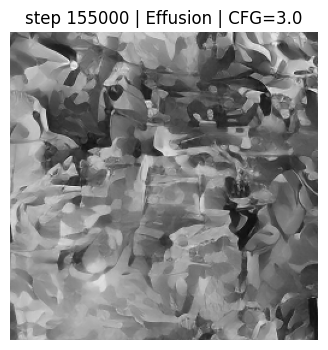

lr=1.20e-05
[step 155500 | epoch 53] train 0.1768 | val 0.1742
lr=1.17e-05
[step 156000 | epoch 53] train 0.1761 | val 0.1740


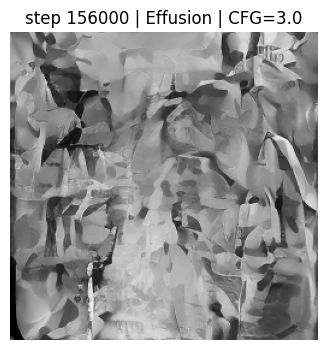

lr=1.14e-05
[step 156500 | epoch 53] train 0.1736 | val 0.1735
lr=1.12e-05
[step 157000 | epoch 53] train 0.1738 | val 0.1733


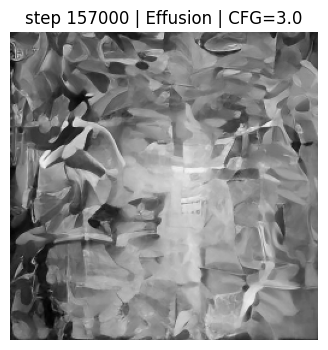

[EPOCH 53] train 0.1765 | val 0.1743
lr=1.09e-05
[step 157500 | epoch 54] train 0.1754 | val 0.1737
lr=1.07e-05
[step 158000 | epoch 54] train 0.1769 | val 0.1734


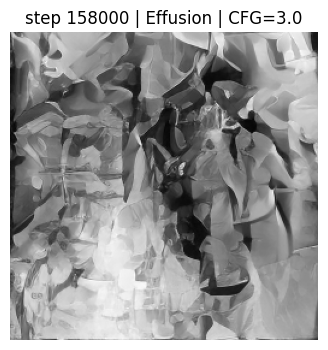

lr=1.05e-05
[step 158500 | epoch 54] train 0.1718 | val 0.1729
lr=1.02e-05
[step 159000 | epoch 54] train 0.1764 | val 0.1759


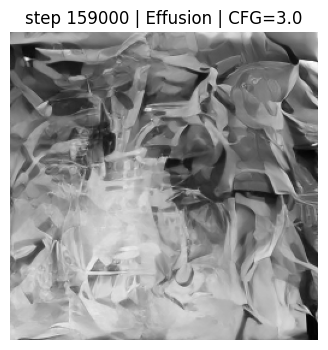

lr=9.97e-06
[step 159500 | epoch 54] train 0.1769 | val 0.1764
[EPOCH 54] train 0.1758 | val 0.1726
lr=9.74e-06
[step 160000 | epoch 55] train 0.1619 | val 0.1767


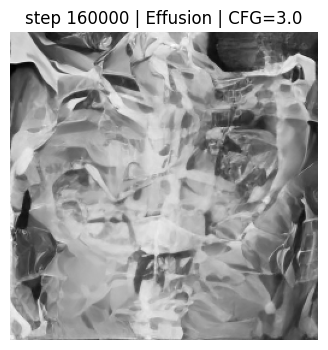

lr=9.50e-06
[step 160500 | epoch 55] train 0.1737 | val 0.1735
lr=9.27e-06
[step 161000 | epoch 55] train 0.1726 | val 0.1750


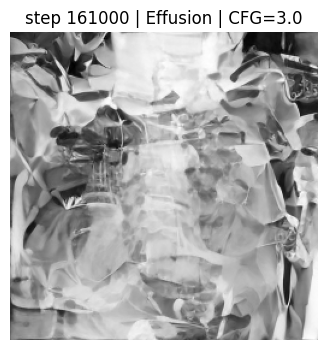

lr=9.04e-06
[step 161500 | epoch 55] train 0.1734 | val 0.1741
lr=8.82e-06
[step 162000 | epoch 55] train 0.1752 | val 0.1750


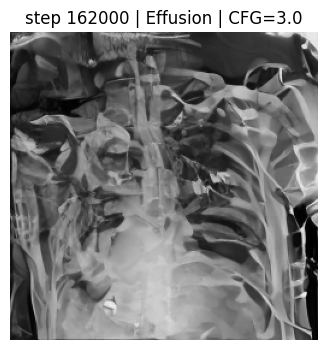

lr=8.59e-06
[step 162500 | epoch 55] train 0.1754 | val 0.1754
[EPOCH 55] train 0.1741 | val 0.1744
lr=8.37e-06
[step 163000 | epoch 56] train 0.1709 | val 0.1747


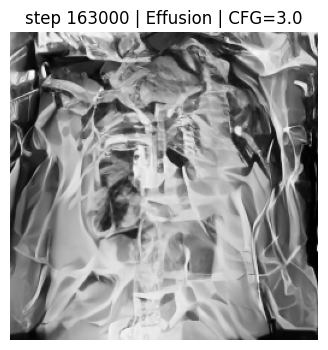

lr=8.15e-06
[step 163500 | epoch 56] train 0.1726 | val 0.1742
lr=7.94e-06
[step 164000 | epoch 56] train 0.1757 | val 0.1752


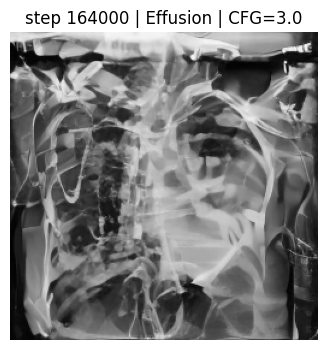

lr=7.72e-06
[step 164500 | epoch 56] train 0.1747 | val 0.1740
lr=7.51e-06
[step 165000 | epoch 56] train 0.1748 | val 0.1728


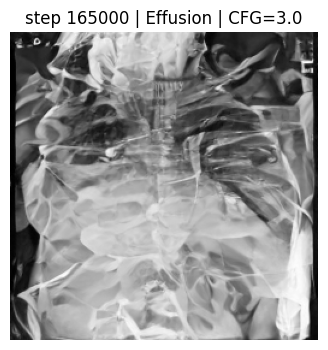

lr=7.31e-06
[step 165500 | epoch 56] train 0.1749 | val 0.1706
[EPOCH 56] train 0.1744 | val 0.1724
lr=7.10e-06
[step 166000 | epoch 57] train 0.1722 | val 0.1730


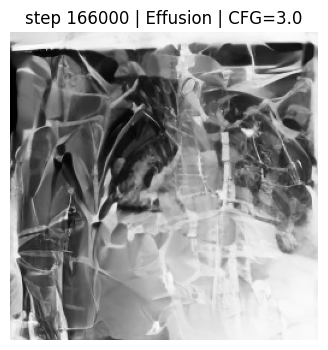

lr=6.90e-06
[step 166500 | epoch 57] train 0.1745 | val 0.1751
lr=6.70e-06
[step 167000 | epoch 57] train 0.1748 | val 0.1737


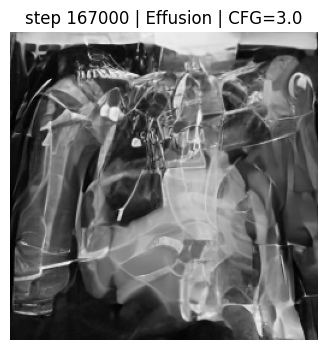

lr=6.50e-06
[step 167500 | epoch 57] train 0.1733 | val 0.1726
lr=6.31e-06
[step 168000 | epoch 57] train 0.1748 | val 0.1745


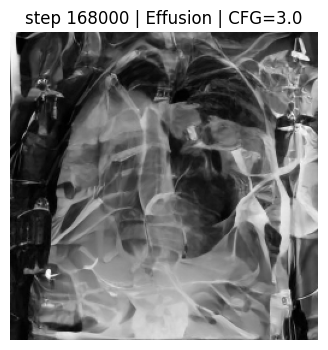

[EPOCH 57] train 0.1738 | val 0.1723
lr=6.12e-06
[step 168500 | epoch 58] train 0.1741 | val 0.1735
lr=5.93e-06
[step 169000 | epoch 58] train 0.1729 | val 0.1759


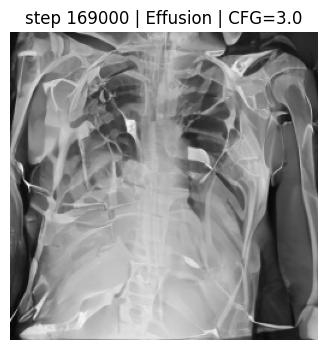

lr=5.74e-06
[step 169500 | epoch 58] train 0.1719 | val 0.1746
lr=5.56e-06
[step 170000 | epoch 58] train 0.1726 | val 0.1736


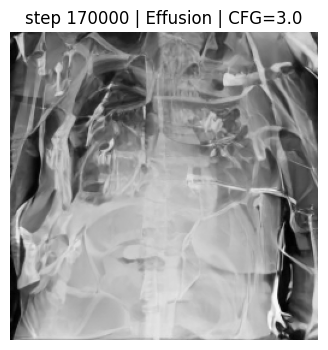

lr=5.38e-06
[step 170500 | epoch 58] train 0.1741 | val 0.1744
lr=5.20e-06
[step 171000 | epoch 58] train 0.1750 | val 0.1749


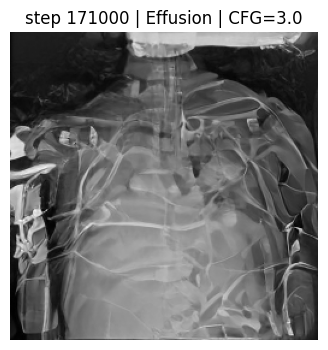

[EPOCH 58] train 0.1733 | val 0.1726
lr=5.03e-06
[step 171500 | epoch 59] train 0.1751 | val 0.1732
lr=4.85e-06
[step 172000 | epoch 59] train 0.1720 | val 0.1739


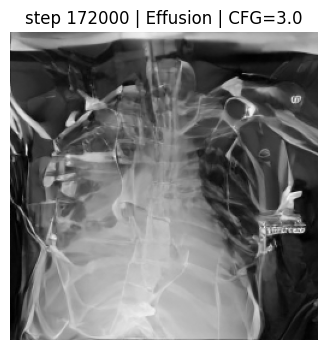

lr=4.68e-06
[step 172500 | epoch 59] train 0.1698 | val 0.1715
lr=4.52e-06
[step 173000 | epoch 59] train 0.1727 | val 0.1743


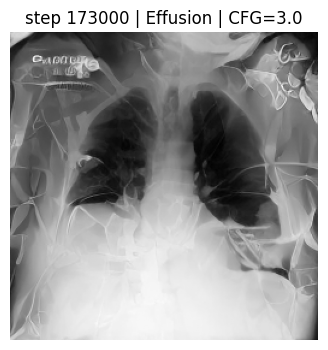

lr=4.35e-06
[step 173500 | epoch 59] train 0.1720 | val 0.1708
lr=4.19e-06
[step 174000 | epoch 59] train 0.1758 | val 0.1749


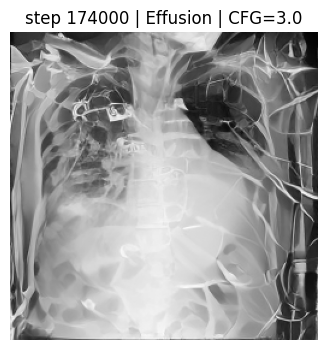

[EPOCH 59] train 0.1727 | val 0.1748
lr=4.04e-06
[step 174500 | epoch 60] train 0.1751 | val 0.1740
lr=3.88e-06
[step 175000 | epoch 60] train 0.1751 | val 0.1744


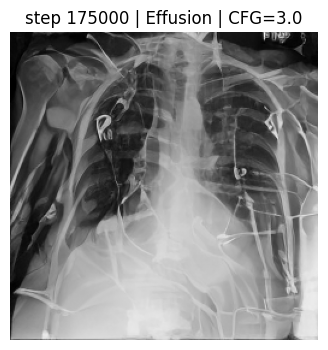

lr=3.73e-06
[step 175500 | epoch 60] train 0.1745 | val 0.1747
lr=3.58e-06
[step 176000 | epoch 60] train 0.1735 | val 0.1719


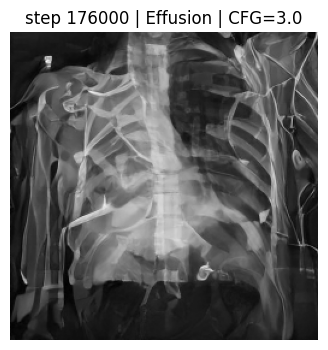

lr=3.44e-06
[step 176500 | epoch 60] train 0.1770 | val 0.1728
[EPOCH 60] train 0.1750 | val 0.1731
lr=3.29e-06
[step 177000 | epoch 61] train 0.1699 | val 0.1736


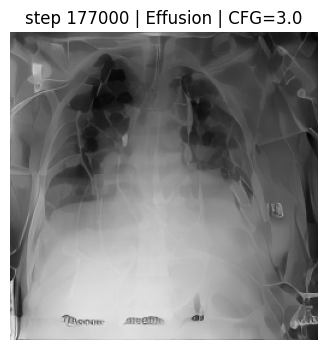

lr=3.15e-06
[step 177500 | epoch 61] train 0.1736 | val 0.1735
lr=3.02e-06
[step 178000 | epoch 61] train 0.1720 | val 0.1720


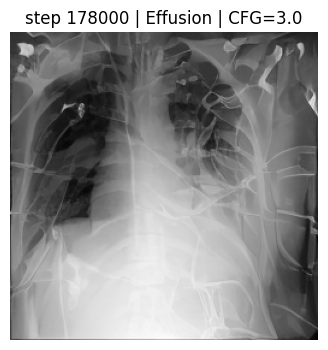

lr=2.88e-06
[step 178500 | epoch 61] train 0.1746 | val 0.1717
lr=2.75e-06
[step 179000 | epoch 61] train 0.1743 | val 0.1732


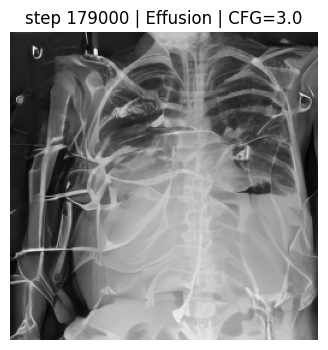

lr=2.62e-06
[step 179500 | epoch 61] train 0.1739 | val 0.1714
[EPOCH 61] train 0.1734 | val 0.1745
lr=2.50e-06
[step 180000 | epoch 62] train 0.1724 | val 0.1731


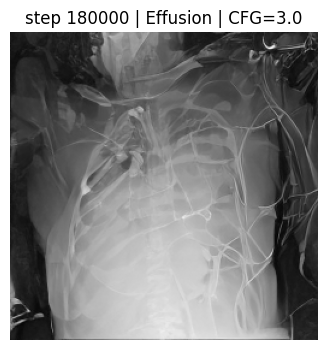

lr=2.37e-06
[step 180500 | epoch 62] train 0.1770 | val 0.1727
lr=2.25e-06
[step 181000 | epoch 62] train 0.1729 | val 0.1746


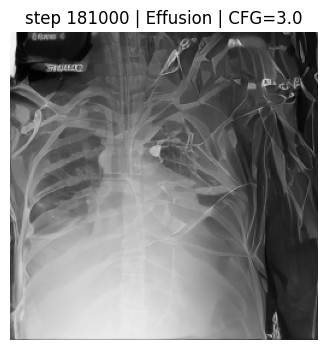

lr=2.14e-06
[step 181500 | epoch 62] train 0.1746 | val 0.1731
lr=2.03e-06
[step 182000 | epoch 62] train 0.1751 | val 0.1744


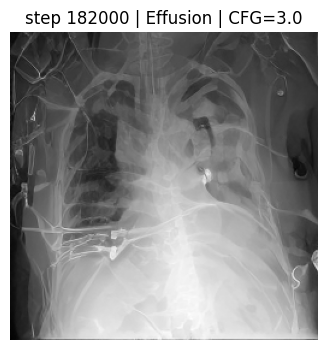

KeyboardInterrupt: 

In [ ]:
print("Start\n")
while True:
    dit.train()
    cond_mlp.train()
    time_mlp.train()

    running_loss = 0.0
    running_count = 0
    epoch_train_losses = []

    for batch in train_loader:
        opt.zero_grad(set_to_none=True)
        loss = train_step(batch)           # fait backward + step
        epoch_train_losses.append(loss)

        running_loss += loss
        running_count += 1


        # log + validation périodique
        if global_step % log_every == 0:
          for g in opt.param_groups:
            print(f"lr={g['lr']:.2e}")

          avg_train = running_loss / running_count

          # ---- VALIDATION ----
          dit.eval()
          cond_mlp.eval()
          time_mlp.eval()

          val_losses = []
          with torch.no_grad():
              for vb in test_loader:
                  val_losses.append(val_step(vb))
          avg_val = sum(val_losses) / max(1, len(val_losses))
          print(f"[step {global_step} | epoch {epoch+1}] train {avg_train:.4f} | val {avg_val:.4f}")

          maybe_preview(global_step, every=1000, steps=50, cfg_scale=3.0, label_name="Effusion")

          # reset accumulateur
          running_loss = 0.0
          running_count = 0

          dit.train()
          cond_mlp.train()
          time_mlp.train()
        global_step += 1


    # --- fin d'époque : stats d'époque + sauvegarde ---
    epoch_train = sum(epoch_train_losses) / max(1, len(epoch_train_losses))

    dit.eval(); cond_mlp.eval(); time_mlp.eval()
    val_losses = []
    with torch.no_grad():
        for vb in test_loader:
            val_losses.append(val_step(vb))
    epoch_val = sum(val_losses) / max(1, len(val_losses))

    print(f"[EPOCH {epoch+1}] train {epoch_train:.4f} | val {epoch_val:.4f}")

    if epoch_val < best_val:
        best_val = epoch_val

        print(f"Save EPOCH {epoch+1}")

        torch.save({
            "dit": dit.state_dict(),
            "cond_mlp": cond_mlp.state_dict(),
            "time_mlp": time_mlp.state_dict(),
            "opt": opt.state_dict(),
            "global_step": global_step,
            "best_val": best_val,
            "epoch": epoch,
            "lr_sched": sched_lr.state_dict(),
            "ema": ema.shadow,
        }, "/content/drive/MyDrive/Colab Notebooks/DiT/best_dit_ckpt.pt")
    epoch += 1


# Conclusion & Resources

In this notebook, we implemented and trained a **Diffusion Transformer (DiT)** on chest X-ray images, using a frozen VAE encoder/decoder for the latent space, classifier-free guidance for conditional generation, and DDIM for efficient sampling.  

The key building blocks were:
- **VAE (AutoencoderKL)**: encodes images into a compressed latent space.
- **Diffusion Process**: progressively adds noise during training, learns to denoise during inference.
- **Transformer (DiT)**: predicts noise on latent patches with conditioning and time embeddings.
- **Classifier-Free Guidance (CFG)**: improves conditional fidelity without external classifiers.
- **EMA (Exponential Moving Average)**: stabilizes weights for cleaner generations.
- **DDIM (Deterministic Diffusion Implicit Models)**: enables fast, deterministic sampling with fewer steps.

---

## References

- **DiT: Diffusion Models with Transformers**  
  [Peebles & Xie, 2022]  
  *https://arxiv.org/abs/2212.09748*

- **DDIM: Denoising Diffusion Implicit Models**  
  [Song, Meng & Ermon, 2020]  
  *https://arxiv.org/abs/2010.02502*

- **DDPM: Denoising Diffusion Probabilistic Models**  
  [Ho, Jain & Abbeel, 2020]  
  *https://arxiv.org/abs/2006.11239*

- **Autoencoding Variational Inference for Image Generation (VAE)**  
  [Kingma & Welling, 2013]  
  *https://arxiv.org/abs/1312.6114*

- **Imagen (Classifier-Free Guidance)**  
  [Saharia et al., 2022]  
  *https://arxiv.org/abs/2205.11487*

- **Stable Diffusion (Latent Diffusion Models)**  
  [Rombach et al., 2022]  
  *https://arxiv.org/abs/2112.10752*


These papers give the full theoretical background to the methods applied here.  
If you want to dive deeper, I recommend starting with **DDPM → DDIM → LDM → DiT** in that order.


# Possible Future Work: Multi-Modality Conditional Generation (AE + Diffusion)

**Goal.** Learn a model that, given an input image from modality $M_1$ (ex: cardiac MRI cine) and a textual/label prompt $y$ specifying a target modality $M_2$ (ex: LGE or echo), generates the *corresponding* image $x_2$:

$$
(x_1, x_2, y) \sim D, \quad x_1 \in X_{M_1}, \; x_2 \in X_{M_2}, \; y \in Y.
$$

### 1) Latent Variable Setup

Two possible designs:

**A. Shared latent space**

- An **encoder** $E_\phi$ maps either modality to a *shared* latent:
  $$
  q_\phi(z \mid x) = N\big(\mu_\phi(x), \Sigma_\phi(x)\big),\quad z \in \mathbb{R}^{h \times w \times c}.
  $$

- A **decoder** $D_\phi$ reconstructs either modality conditioned on a modality token $m \in \{M_1, M_2\}$:

  $$
  \hat{x} = D_\phi\!\big(z, m\big).
  $$

- Train with a **modality-aware VAE**:

  $$
  Loss_{\text{VAE}} =
  \mathbb{E}_{q_\phi(z\mid x)}\big[\|x - D_\phi(z, m)\|_1\big]
  + \beta \, \mathrm{KL}\big(q_\phi(z\mid x) \,\|\, N(0,I)\big).
  $$

**B. Dual encoders, shared latent (two AEs)**

- $E^1_\phi: X_{M_1}\!\to\! z$, $E^2_\phi: X_{M_2}\!\to\! z$, and decoders $D^1_\phi, D^2_\phi$.

- Encourage **alignment** of $z_1=E^1(x_1)$ and $z_2=E^2(x_2)$ for paired data with:

  - **Latent matching**: $\|z_1 - z_2\|_2^2$,
  - or **contrastive** loss in latent space,

> Shared latent spaces simplify the diffusion model because both modalities lie on the same manifold.

---

### 2) Conditional Diffusion in Latent Space

Train a diffusion model to generate the **target latent** $z_2$ **conditioned on** the **source latent** $z_1$ and prompt $y$.

**Forward (noising) process on target latent $z_2$:**

$$
z_{2,t} = \sqrt{\bar{\alpha}_t}\, z_2 + \sqrt{1-\bar{\alpha}_t}\,\epsilon,\quad \epsilon \sim N(0, I).
$$

**Score model (DiT) predicts noise** conditioned on $(z_1,y)$:

$$
\hat{\epsilon}_\theta = \epsilon_\theta\big(z_{2,t},\, t,\, c(z_1,y)\big),
$$

where $c(\cdot)$ is a **conditioning encoder** that turns $(z_1,y)$ into tokens for the Transformer

**Training objective (noise MSE):**

$$
Loss_{\text{diff}} =
\mathbb{E}\Big[\;\big\|\epsilon - \epsilon_\theta\big(z_{2,t}, t, c(z_1,y)\big)\big\|_2^2 \;\Big].
$$

---

### 3) Inference

Given $x_1$ and desired target $y$ (ex: LGE):

1. **Encode source**: $z_1 = E(x_1)$.

2. **Initialize**: sample $z_{2,T} \sim N(0, I)$.

3. **Reverse diffusion** (DDIM / DDPM), conditioned on $(z_1,y)$:

   $$
   z_{2,0} \leftarrow \text{Sampler}\big(\epsilon_\theta(\cdot \mid z_1, y)\big).
   $$

4. **Decode target**: $\hat{x}_2 = D(z_{2,0}, \, m\!=\!M_2)$.

---

### 4) Conditioning Mechanisms

- **Concatenated tokens**: tokenize $z_{2,t}$ as usual; prepend:

  - a **time token**,

  - a **prompt token** $e_y$ (from an MLP or text encoder),

  - a **source-latent context** obtained by tokenizing $z_1$

- **Classifier-Free Guidance**: drop $(z_1,y)$ with prob $p$ during training; at inference blend uncond/cond predictions with scale $\gamma$.

---

### 5) Data Requirements & Variants

- **Paired data** $(x_1,x_2)$ .

- Prompts $y$ can be **discrete** (one-hot) or **text** .




